

***
# <font color=red> Application of Machine Learning Algorithms on Prediction of Fetal Risk using Cardiotocographic Data </font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure </font></p>

***

## Overview:
This notebook provides a sample CTG classification technique.

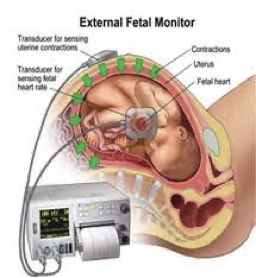             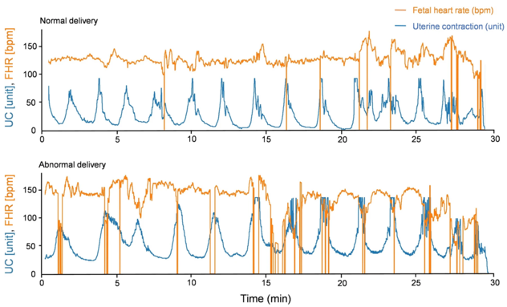

Features have already been extracted from Cardiotocogram exams and saved in a tabular format. This notebook demonstrates simple steps for Exploratory Data Analysis, training a model and deploying it to production.

---
## Contents:

* <a href='#intro'>Introduction</a>
    * <a href="#dataset">Dataset</a>
* <a href="#eda">Exploratory Data Analysis (EDA)</a>
    * <a href="#ads_analysis">ADS Dataset Analysis</a>
    * <a href="#pairplots">Pair Plots</a>
    * <a href="#Data_Distribution">Label Distribution</a>
    * <a href="#ads_eda_reco">ADS EDA Recommendations: feature selection and resampling</a>
    * <a href="#feature_dist">Feature Distribution</a>
    * <a href="#normalize">Scaling Features</a>
* <a href='#create'>Model Selection</a>
    * <a href="#split">Split Train and Test datasets and Separate Target variable</a>
    * <a href="#compare_different_models">Compare Model performance</a>
    * <a href="#ads_eval">Compare models with ADS Evaluator</a>
    * <a href="#create_pipeline">Create the Production Model</a>
* <a href='#serialize'>Model Deployment</a>
    * <a href='#serialize_sklearnmodel'>Create a Serialized Model</a>
    * <a href='#serialize_prepare'>Prepare the Model Artifacts</a>
    * <a href='#serialize_verify'>Verify: Test the Model Locally</a>
    * <a href='#serialize_save'>Save the Model in the Model Catalog</a>
    * <a href='#serialize_deploy'>Deploy</a>
    * <a href='#serialize_predict'>Predict</a>
* <a href='#req_resp'>Invoking the Endpoint</a>    
* <a href='#clean_up'>Clean Up</a>
* <a href='#ref'>References</a>    

---

**Important:**

Some field require replacement. They are surrounded with `<>`. For example `database_name = "<database_name>"` would become `database_name = "production"`.

---

<font color="gray">
Datasets are provided as a convenience. Datasets are considered third-party content and are not considered materials under your agreement with Oracle.
      
You can access the `fetal_health` dataset license <a href="https://onlinelibrary.wiley.com/doi/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9" target="_blank">here</a>.
    

</font>

This Notebook has been tested with the `generalml_p37_cpu_v1` conda environment.

In [2]:
# Install and upgrade required packages. The -q flag makes it silent.
! pip install -U oci-cli==3.10.3 -q
! pip install -U oracle-ads[notebook,boosted,data]==2.6.2 -q
! pip install xlrd -q

In [3]:
import ads
import io
import logging
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import oci
import pandas as pd
import requests
import seaborn as sns
import tempfile
import warnings

from ads.catalog.model import ModelCatalog
from ads.common.model import ADSModel
from ads.common.model_metadata import UseCaseType
from ads.dataset.factory import DatasetFactory
from ads.evaluations.evaluator import ADSEvaluator
from ads.model.framework.sklearn_model import SklearnModel
from ads.model.framework.xgboost_model import XGBoostModel

from shutil import rmtree

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder, PowerTransformer, StandardScaler,  QuantileTransformer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
warnings.filterwarnings('ignore')

In [4]:
ads.__version__

'2.6.2'

<a id='intro'></a>
# Introduction

A cardiotocogram (CTG) is a trace of the fetus heart-beat, usually recorded prior or during labor. The trace includes peaks of various shapes and at various frequencies, accelerating or decelerating which can be indicators of risky or abnormal fetal health.

<a id="dataset"></a>
## Dataset

This dataset contains 2126 records of features extracted from cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

1. Normal
2. Risky
3. Abnormal

In the following cell, the data will be read into a pandas Dataframe from the [archive url](https://archive.ics.uci.edu/ml/machine-learning-databases/00193/CTG.xls).

The data file is in the Excel format, with multiple sheets. The sheet of interest is the `Data` sheet, which includes extra header,  extra columns and also extra statistics rows at the bottom that can be identified as having NaNs, while the dataset itself does not have any. Sheet and columns of interest are specified during the loading task, and extra rows are dropped using `dropna()`.

In [5]:
def load_dataset():
    data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00193/CTG.xls'
    column_names = ['baseline value', 'accelerations', 'fetal_movement',
           'uterine_contractions', 'light_decelerations', 'severe_decelerations',
           'prolongued_decelerations', 'abnormal_short_term_variability',
           'mean_value_of_short_term_variability',
           'percentage_of_time_with_abnormal_long_term_variability',
           'mean_value_of_long_term_variability', 'histogram_width',
           'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
           'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
           'histogram_median', 'histogram_variance', 'histogram_tendency',
           'fetal_health']

    df = pd.read_excel(data_url, sheet_name='Data', header=1, usecols='K:AE,AT', names=column_names)
    df = df.dropna()
    return df

df = load_dataset()

Take a look at the first few records so that you can get an understanding of the data.

In [6]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006380,0.0,0.006380,0.003190,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003322,0.0,0.008306,0.003322,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.002561,0.0,0.007682,0.002561,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.006515,0.0,0.008143,0.000000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


<a id="eda"></a>
# Exploratory Data Analysis (EDA)

The label column is called `fetal_health`. Remap the column as a string to make it a categorical type so that the dataset will be detected as a `MultiClassClassificationDataset`.

The DatasetFactory from Oracle ADS provides a way to create an ADSDataSet from a dataframe. By mapping to string type, it is detected as a `MultiClassClassificationDataset`.

ADS Datasets provide simple functionalities to facilitate Exploratory Data Analysis (EDA).

In [7]:
label_col = 'fetal_health'
df[label_col] = df[label_col].map({1.0: '1 - Normal', 2.0: '2 - Risky', 3.0: '3 - Abnormal'})
ds = DatasetFactory.from_dataframe(df).set_target(label_col)
ds

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

fetal_health,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
2 - Risky,120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000,0.500000,43.000000,2.400000,64.000000,62.000000,126.000000,2.000000,0.000000,120.000000,137.000000,121.000000,73.000000,1.000000
1 - Normal,132.000000,0.006380,0.000000,0.006380,0.003190,0.000000,0.000000,17.000000,2.100000,0.000000,10.400000,130.000000,68.000000,198.000000,6.000000,1.000000,141.000000,136.000000,140.000000,12.000000,0.000000
1 - Normal,133.000000,0.003322,0.000000,0.008306,0.003322,0.000000,0.000000,16.000000,2.100000,0.000000,13.400000,130.000000,68.000000,198.000000,5.000000,1.000000,141.000000,135.000000,138.000000,13.000000,0.000000
1 - Normal,134.000000,0.002561,0.000000,0.007682,0.002561,0.000000,0.000000,16.000000,2.400000,0.000000,23.000000,117.000000,53.000000,170.000000,11.000000,0.000000,137.000000,134.000000,137.000000,13.000000,1.000000
1 - Normal,132.000000,0.006515,0.000000,0.008143,0.000000,0.000000,0.000000,16.000000,2.400000,0.000000,19.900000,117.000000,53.000000,170.000000,9.000000,0.000000,137.000000,136.000000,138.000000,11.000000,1.000000


MultiClassClassificationDataset(target: fetal_health) 2,126 rows, 22 columns

<a id="ads_analysis"></a>
## ADS Dataset Analysis
The `.show_in_notebook()` method provides a comprehensive view of the dataset features statistics, visualization and correlations.

Note: It may take some time to render all the charts, even without opening the tabs, so please be patient.

In [8]:
ds.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: MultiClassClassificationDataset</h3><h3>2,126 Rows, 22 Columns</h3><…

Many columns have zeros. This is expected as these are markers of abnormal behavior of the CTG traces.

<a id="pairplots"></a>
## Pair Plots

Another usually way of visualizing the data is to render pair plots for various columns. This was limited to 5 columns for readability.

The diagonal of the pair plot gives the distribution of each class for the single feature, while the scatter plots show the relationships between 2 features. The separation of dot clusters gives an indication about how the classes can be identified using these features. 

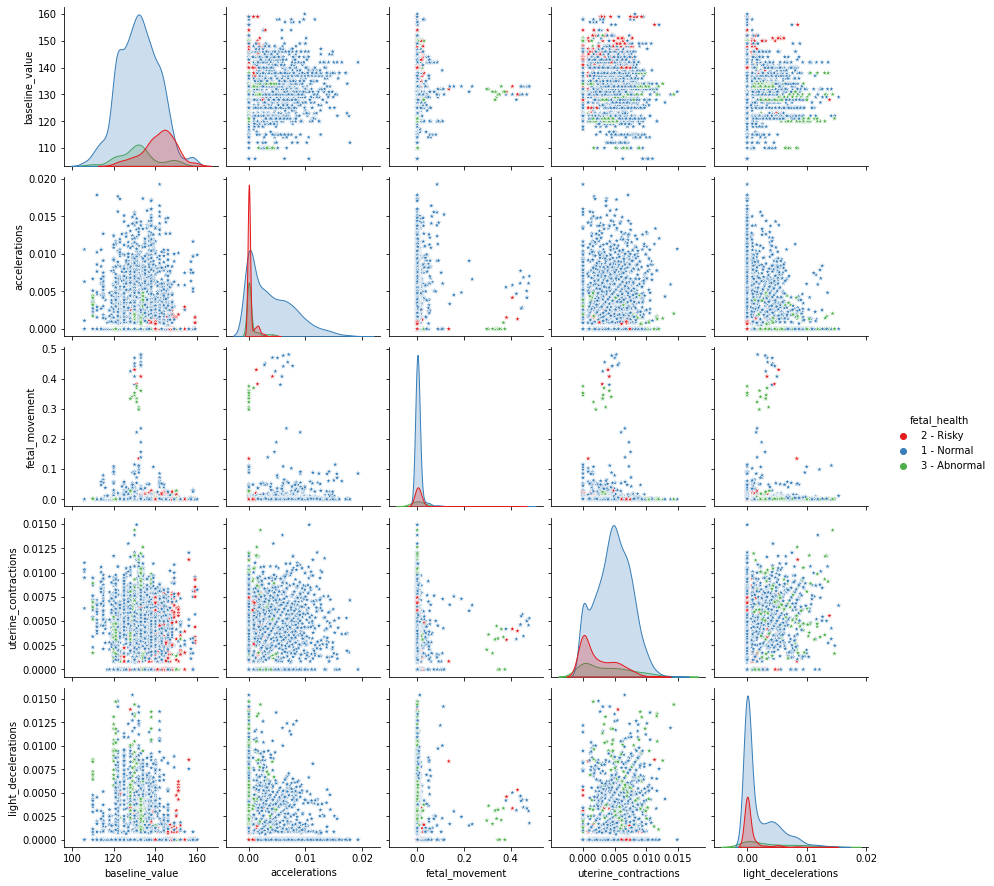

In [9]:
columns = list(df.columns)[0:5]
sns.pairplot(df, vars=columns, palette="Set1", hue=label_col, markers='*')

<a id="Data_Distribution"></a>
## Label Distribution

Next, look at the distribution of the target classes. It is highly imbalanced towards the normal class, so the dataset may need to be re-sampled for machine learning models to efficiently learn from the other classes.

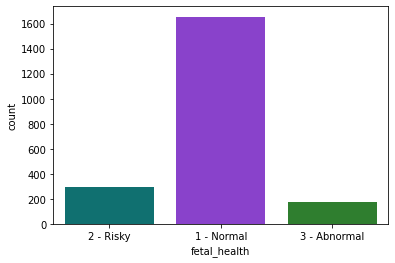

1 - Normal      1655
2 - Risky        295
3 - Abnormal     176
Name: fetal_health, dtype: int64


In [10]:
sns.countplot(x=label_col, data=df)
plt.show()
print(df.fetal_health.value_counts())

<a id='ads_eda_reco'></a>
## ADS EDA Recommendations: feature selection and resampling

Next look at the recommendation for feature selection, use the defaults.

The class is highly imbalanced, so fix it by choosing `Up-sample`.

Once done with applying the recommendation, move to the next cell to get the transformed dataset.

In [11]:
ds.get_recommendations()

Output()

In [12]:
ds2 = ds.get_transformed_dataset()

The dataset was upsampled, so the number of row increased, the shape shows:

In [13]:
ds2.shape

(4965, 19)

<a id="feature_dist"></a>
## Distribution of Features

Using seaborn boxplots, the feature distributions can be displayed in one row.

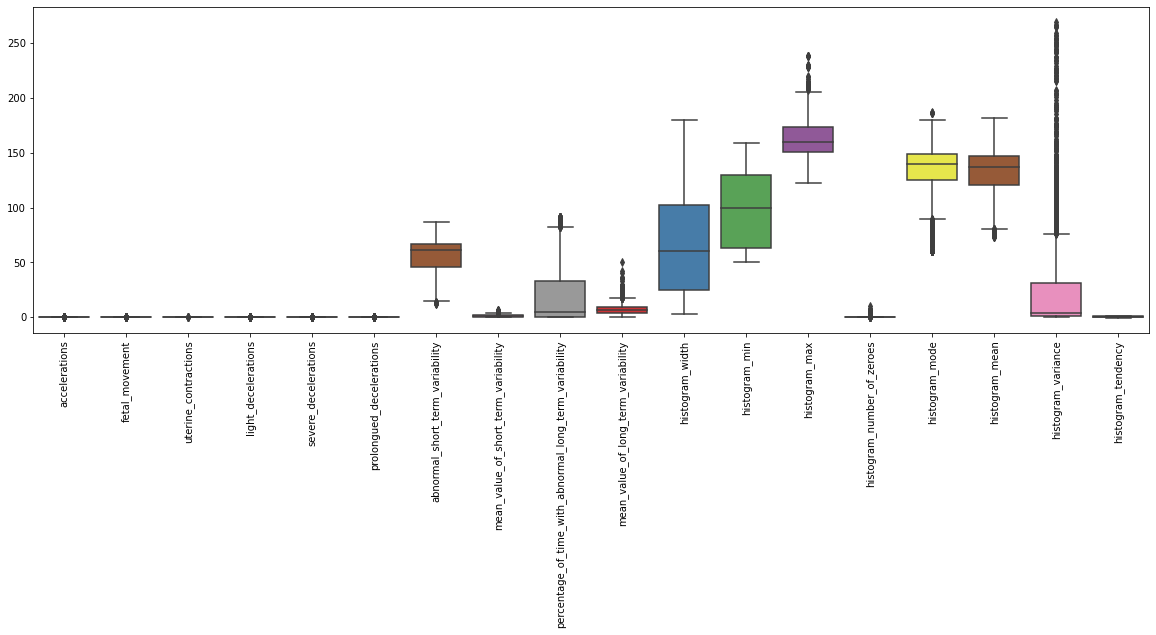

In [14]:
plt.figure(figsize=(20,6))
sns.boxplot(data=ds2.to_pandas(), palette="Set1")
plt.xticks(rotation=90)
plt.show()

<a id="normalize"></a>
## Scaling Features

Because the features are on different scales, the plot is not easy to read. 

To visualize the distribution of features relative to each other more easily, one option is to rescale the data. Scaling techniques include rescaling between Min and Max, or normalizing around 0 using standard deviation.

The data shows that some of the features are quite skewed, a StandardScaler would not correct for this, so a QuantileTransformer scaler might be a better option to rescale each feature towards a normal distribution.

Note that tree-based classifiers can handle skewed data without problems, but most classifiers relying on a distance metric for convergence perform better with a normalized dataset.

Since the goal is to find a suitable classifier among a variety of options, the data is normalized. If the preferred classifier ends up being tree-based, this step can be skipped when creating the final model for production.


In [15]:
scaler =  QuantileTransformer(output_distribution="normal")
scaled_ds = scaler.fit_transform(ds2.drop(label_col, axis=1), ds2[label_col])

Recreate a Dataframe from the output numpy array, and then a Dataset object from this dataframe, to ease the work downstream

In [16]:
df2 = pd.DataFrame(scaled_ds, columns=ds2.columns[ds2.columns != label_col], index=ds2.index)
df2[label_col] = ds2[label_col]
ds3 = DatasetFactory.from_dataframe(df2).set_target(label_col)
ds3

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

fetal_health,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_variance,histogram_tendency
2 - Risky,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.057485,-0.414267,0.880888,-0.875354,0.032625,-0.744694,-2.877846,-5.199338,-0.892038,0.016310,1.174387,5.199338
1 - Normal,1.346746,-5.199338,0.831286,0.642543,-5.199338,-5.199338,-2.456904,0.849874,-5.199338,0.918498,1.346386,-0.485069,1.679303,1.140077,0.062770,-0.021329,0.345485,-0.336178
1 - Normal,0.945301,-5.199338,1.378443,0.664329,-5.199338,-5.199338,-2.611712,0.849874,-5.199338,1.387908,1.346386,-0.485069,1.679303,1.140077,0.062770,-0.072829,0.381675,-0.336178
1 - Normal,0.826698,-5.199338,1.231165,0.553327,-5.199338,-5.199338,-2.611712,1.070745,-5.199338,2.283465,0.985610,-1.355761,0.524976,-5.199338,-0.086674,-0.129582,0.381675,5.199338
1 - Normal,1.366617,-5.199338,1.340988,-5.199338,-5.199338,-5.199338,-2.611712,1.070745,-5.199338,2.053835,0.985610,-1.355761,0.524976,-5.199338,-0.086674,-0.021329,0.303168,5.199338


MultiClassClassificationDataset(target: fetal_health) 4,965 rows, 19 columns

Now re-create the distribution plot

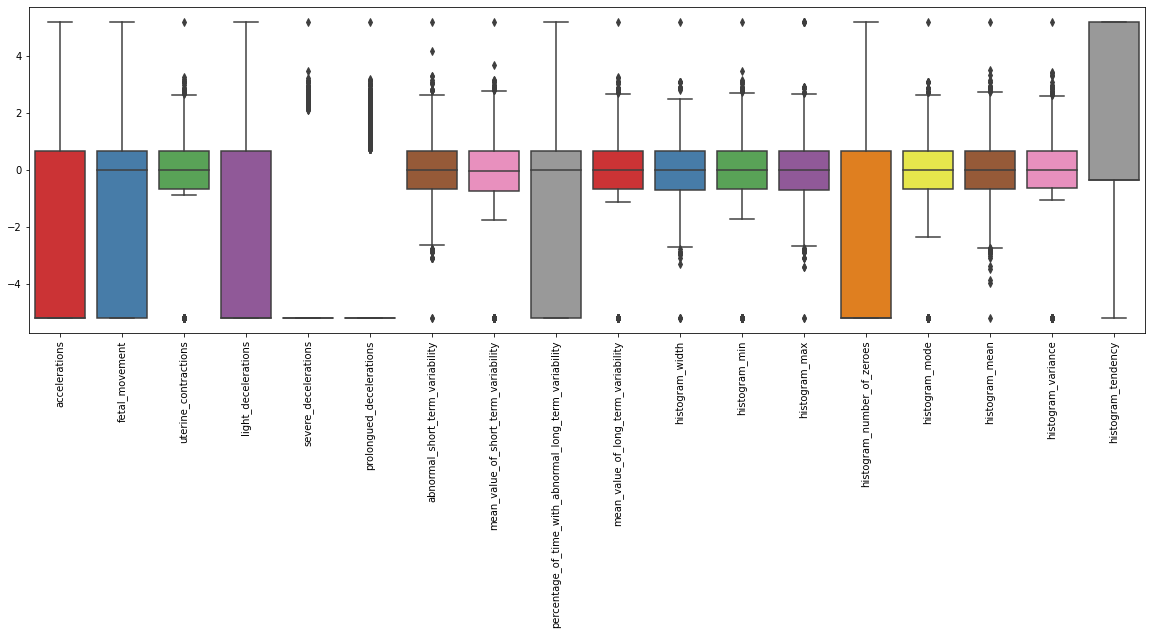

In [17]:
plt.figure(figsize=(20,6))
sns.boxplot(data=df2, palette="Set1")
plt.xticks(rotation=90)
plt.show()

Violin plots can be used to show the distribution of each class in each feature, and provide a good visual of what feature may be most able to discriminate between the different classes. When there are only 2 classes, using the `split` option shows the violin split between the 2 classes, as opposed to showing each class separately.

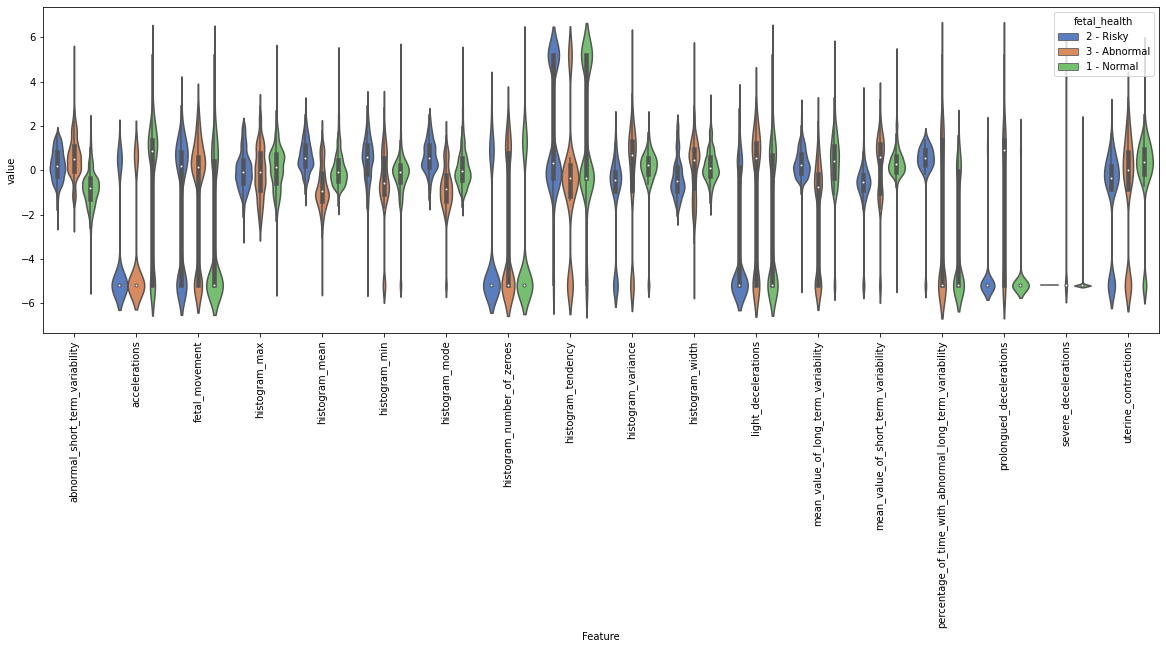

In [18]:
plt.figure(figsize=(20,6))
p = sns.violinplot(x='level_1',
               y=0,
               hue=label_col,
               data=df2.set_index([label_col]).stack().reset_index().sort_values('level_1'), 
               palette="muted", 
               y_label="value"
              )
p.set_xlabel('Feature')
p.set_ylabel('value')
plt.xticks(rotation=90)
plt.show()

<a id='create'></a>
# Model Selection

The data has been pre-processed and does not need any specific transformation as it is all floats. If there had been categorical features, they would have required additional encoding.

The next step is to try various models and see which one performs best.

<a id="split"></a>
## Split Train and Test datasets and Separate Target variable

Split the data into train and test sets. The following cell creates a 75-25 split. That is, the model will be trained on 75% of the data. The remaining 25% will be used to validate the model.

The ADSDataset already separated the target variable when using the `set_target` method on creation, so each data subset has a `X` (features) and `y` (target) property.


In [19]:
train, test = ds3.train_test_split(0.25)
X_train = train.X
X_test = test.X
y_train = train.y
y_test = test.y

selected_features = train.X.columns


<a id='compare_different_models'></a>
## Compare Model Performance

In this section, multiple models are prepared with default settings, they are then trained on the training set and their performance is compared by looking at standard metrics: accuracy, precision, recall, f1-score etc. 

Confusion matrix is displayed to a sense of the rate of false positive and false negatives.

In [20]:
model_accuracy = pd.DataFrame(columns=['Model','Accuracy'])
models = {
          "KNeighborsClassifier" : KNeighborsClassifier(),
          "DecisionTreeClassifier" : DecisionTreeClassifier(),
          'RandomForestClassifier' : RandomForestClassifier(),
          'GradientBoostingClassifier' : GradientBoostingClassifier(),
          'XGBClassifier' : XGBClassifier(eval_metric='mlogloss'),
          'LinearSVC': LinearSVC()
          }

for model_name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    print(f"{model_name} scores")
    print(f"Accuracy: {acc}")
    print("Classification report")
    print(classification_report(y_test,y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test,y_pred))
    print('*' * 100,"\n")
    model_accuracy = model_accuracy.append({
        'Model': model_name, 
        'Accuracy': acc, 
        'Train_acc': train_acc
    }, ignore_index=True)

model_accuracy.sort_values(ascending=False, by='Accuracy')

KNeighborsClassifier scores
Accuracy: 0.8977455716586151
Classification report
              precision    recall  f1-score   support

  1 - Normal       0.92      0.85      0.88       433
   2 - Risky       0.84      0.91      0.87       404
3 - Abnormal       0.94      0.94      0.94       405

    accuracy                           0.90      1242
   macro avg       0.90      0.90      0.90      1242
weighted avg       0.90      0.90      0.90      1242

Confusion Matrix:
[[369  51  13]
 [ 27 367  10]
 [  5  21 379]]
**************************************************************************************************** 

DecisionTreeClassifier scores
Accuracy: 0.9500805152979066
Classification report
              precision    recall  f1-score   support

  1 - Normal       0.95      0.93      0.94       433
   2 - Risky       0.92      0.94      0.93       404
3 - Abnormal       0.97      0.98      0.98       405

    accuracy                           0.95      1242
   macro avg       0

,Model,Accuracy,Train_acc
4,XGBClassifier,0.978261,0.999731
2,RandomForestClassifier,0.972625,0.999731
3,GradientBoostingClassifier,0.966184,0.990868
1,DecisionTreeClassifier,0.950081,0.999731
0,KNeighborsClassifier,0.897746,0.944400
5,LinearSVC,0.834138,0.855493


<a id="ads_eval"></a>
## Compare models with ADS Evaluator

The ADS Evaluator package provides many of these features out of the box, allowing to compare several models in a single view, with little code. The models first need to be converted to an ADSModel object, then they can be fed to the ADSEvaluator constructor.

In [21]:
ads_models = [ADSModel.from_estimator(m) for m in models.values()]
evaluator = ADSEvaluator(test, models=ads_models, training_data=train)
evaluator.metrics

,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier,"XGBClassifier', n_estimators=100, n_jobs=4, num_parallel_tree=1, objective='multi:softprob', predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1, tree_method='exact', validate_parameters=1, verbosity=None)",LinearSVC
Accuracy,0.8977,0.9501,0.9726,0.9662,0.9783,0.8341
Hamming distance,0.1023,0.0499,0.0274,0.0338,0.0217,0.1659
precision_weighted,0.9002,0.9502,0.9730,0.9666,0.9786,0.8415
precision_micro,0.8977,0.9501,0.9726,0.9662,0.9783,0.8341
recall_weighted,0.8977,0.9501,0.9726,0.9662,0.9783,0.8341
recall_micro,0.8977,0.9501,0.9726,0.9662,0.9783,0.8341
f1_weighted,0.8980,0.9501,0.9726,0.9662,0.9783,0.8357
f1_micro,0.8977,0.9501,0.9726,0.9662,0.9783,0.8341


,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier,"XGBClassifier', n_estimators=100, n_jobs=4, num_parallel_tree=1, objective='multi:softprob', predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1, tree_method='exact', validate_parameters=1, verbosity=None)",LinearSVC
Accuracy,0.9444,0.9997,0.9997,0.9909,0.9997,0.8555
Hamming distance,0.0556,0.0003,0.0003,0.0091,0.0003,0.1445
precision_weighted,0.9447,0.9997,0.9997,0.9909,0.9997,0.8612
precision_micro,0.9444,0.9997,0.9997,0.9909,0.9997,0.8555
recall_weighted,0.9444,0.9997,0.9997,0.9909,0.9997,0.8555
recall_micro,0.9444,0.9997,0.9997,0.9909,0.9997,0.8555
f1_weighted,0.9444,0.9997,0.9997,0.9909,0.9997,0.8566
f1_micro,0.9444,0.9997,0.9997,0.9909,0.9997,0.8555


The `.show_in_notebook()` method dipslays a visual representation of several useful metrics and curves, including the confusion matrix, ROC curves and Precision / Recall curves.

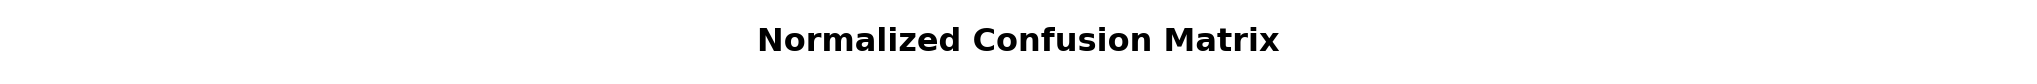

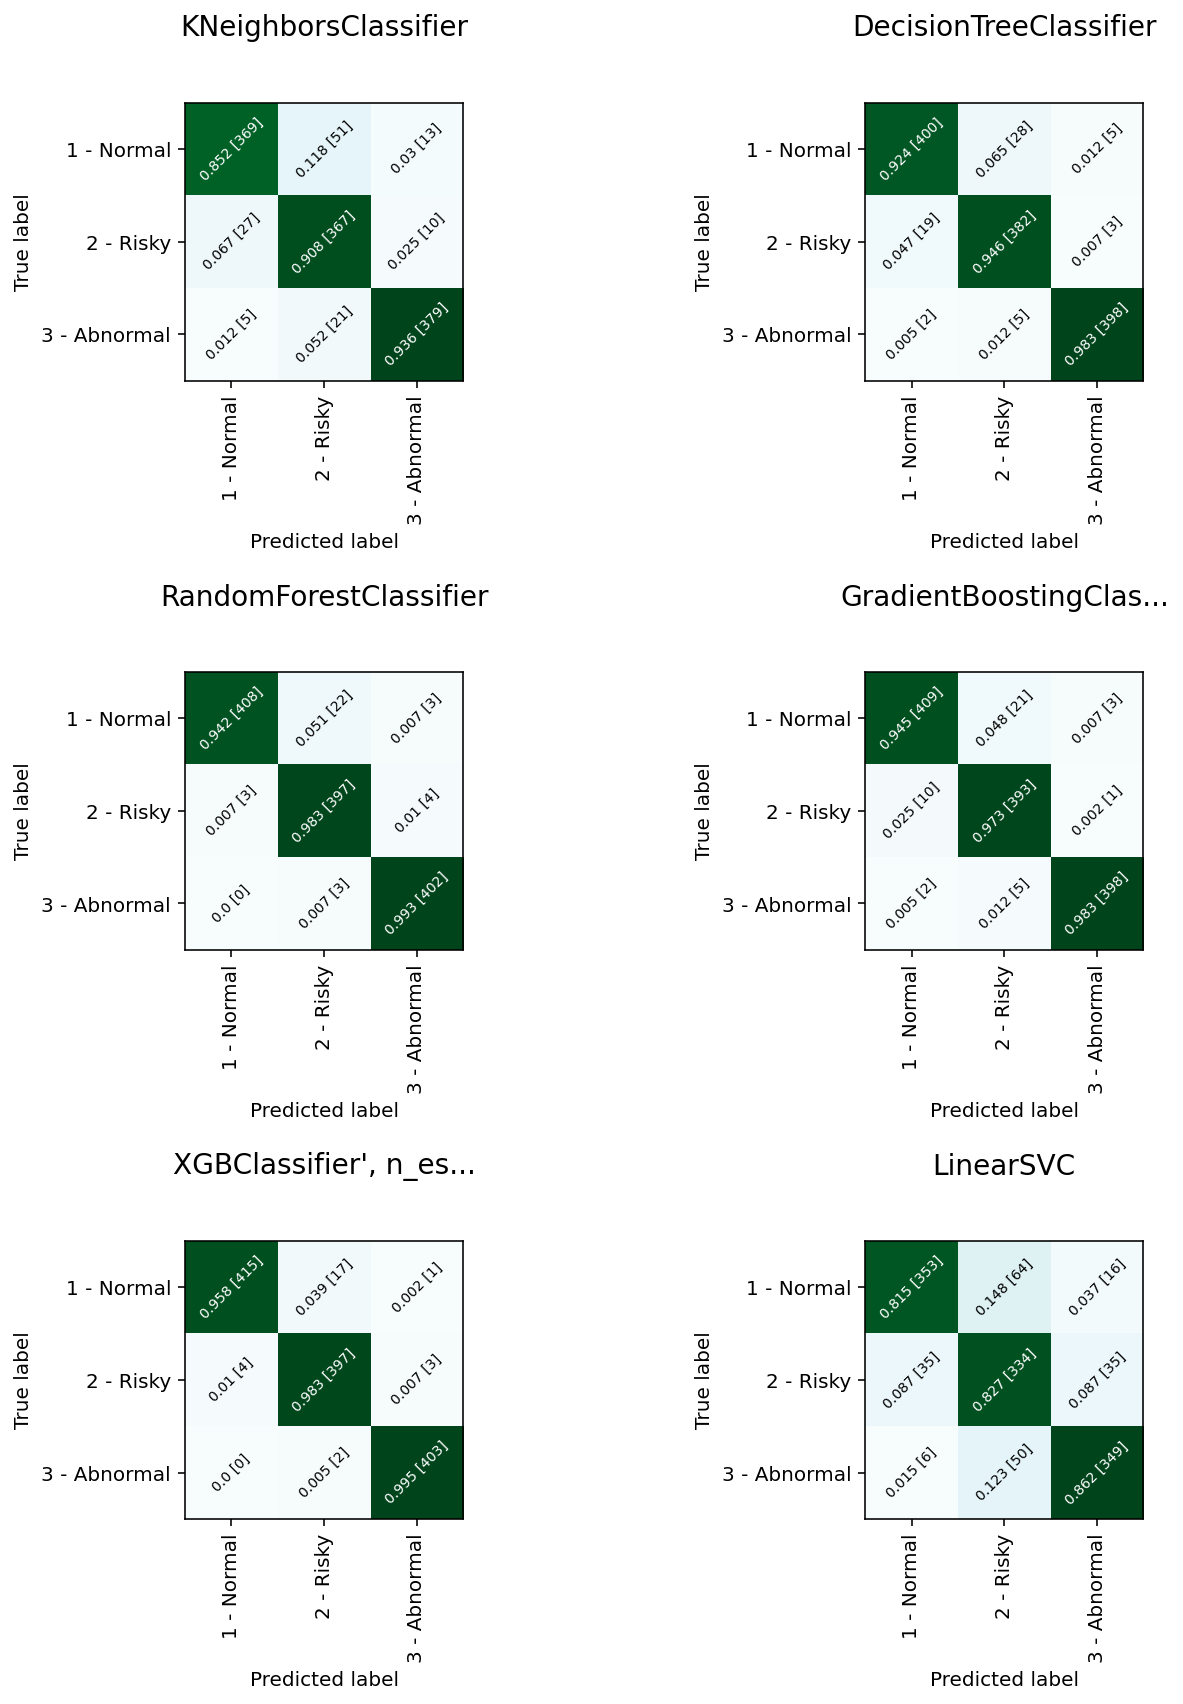

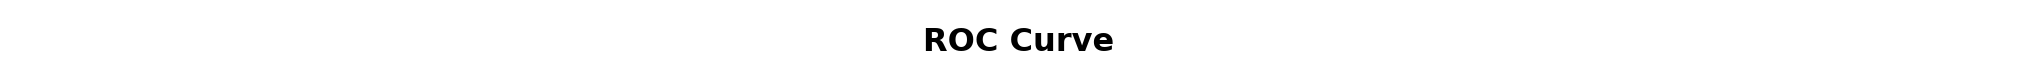

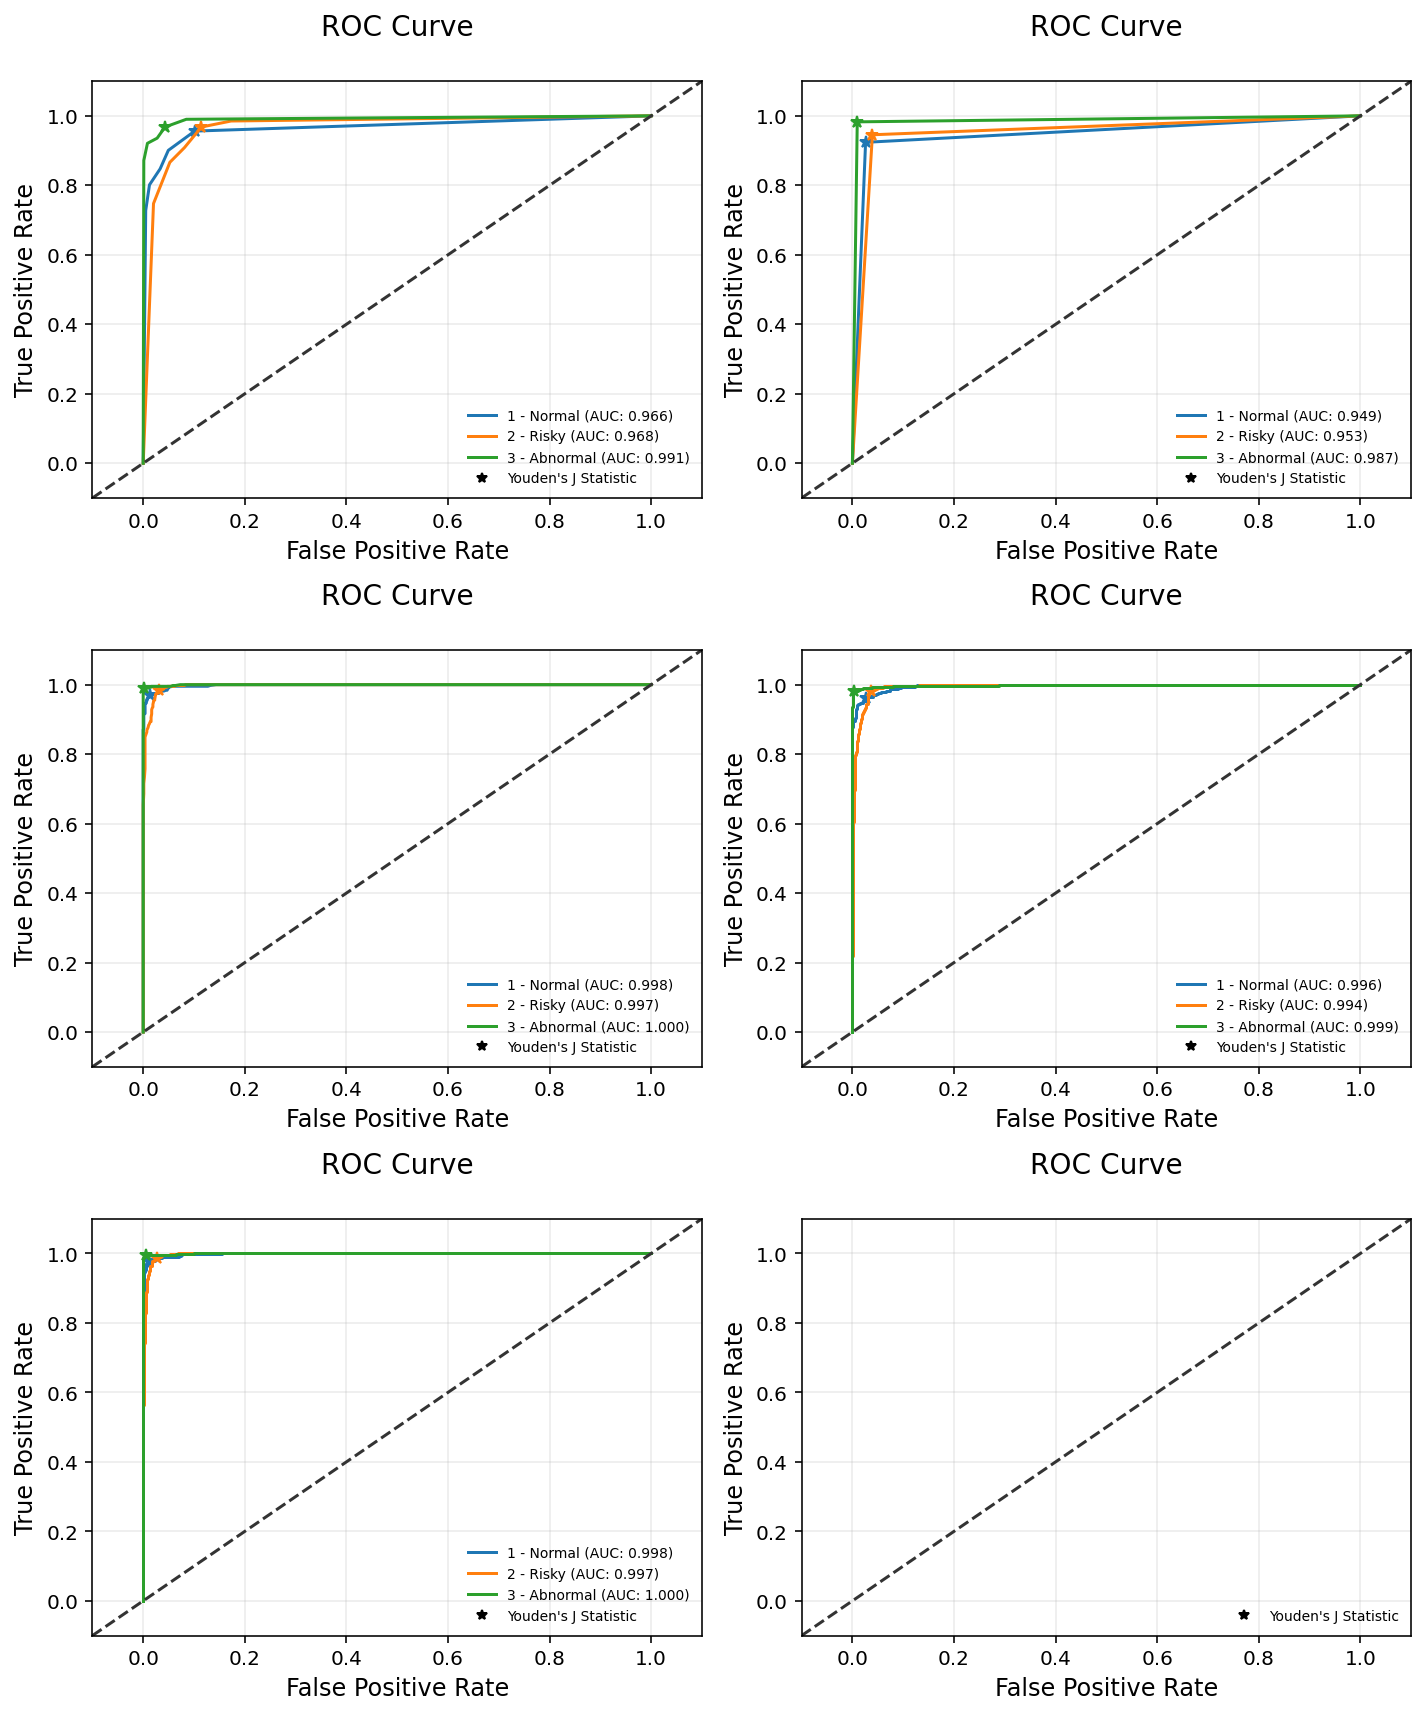

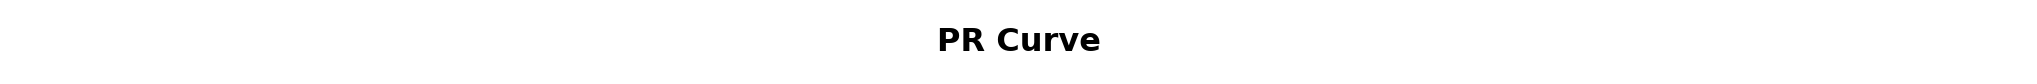

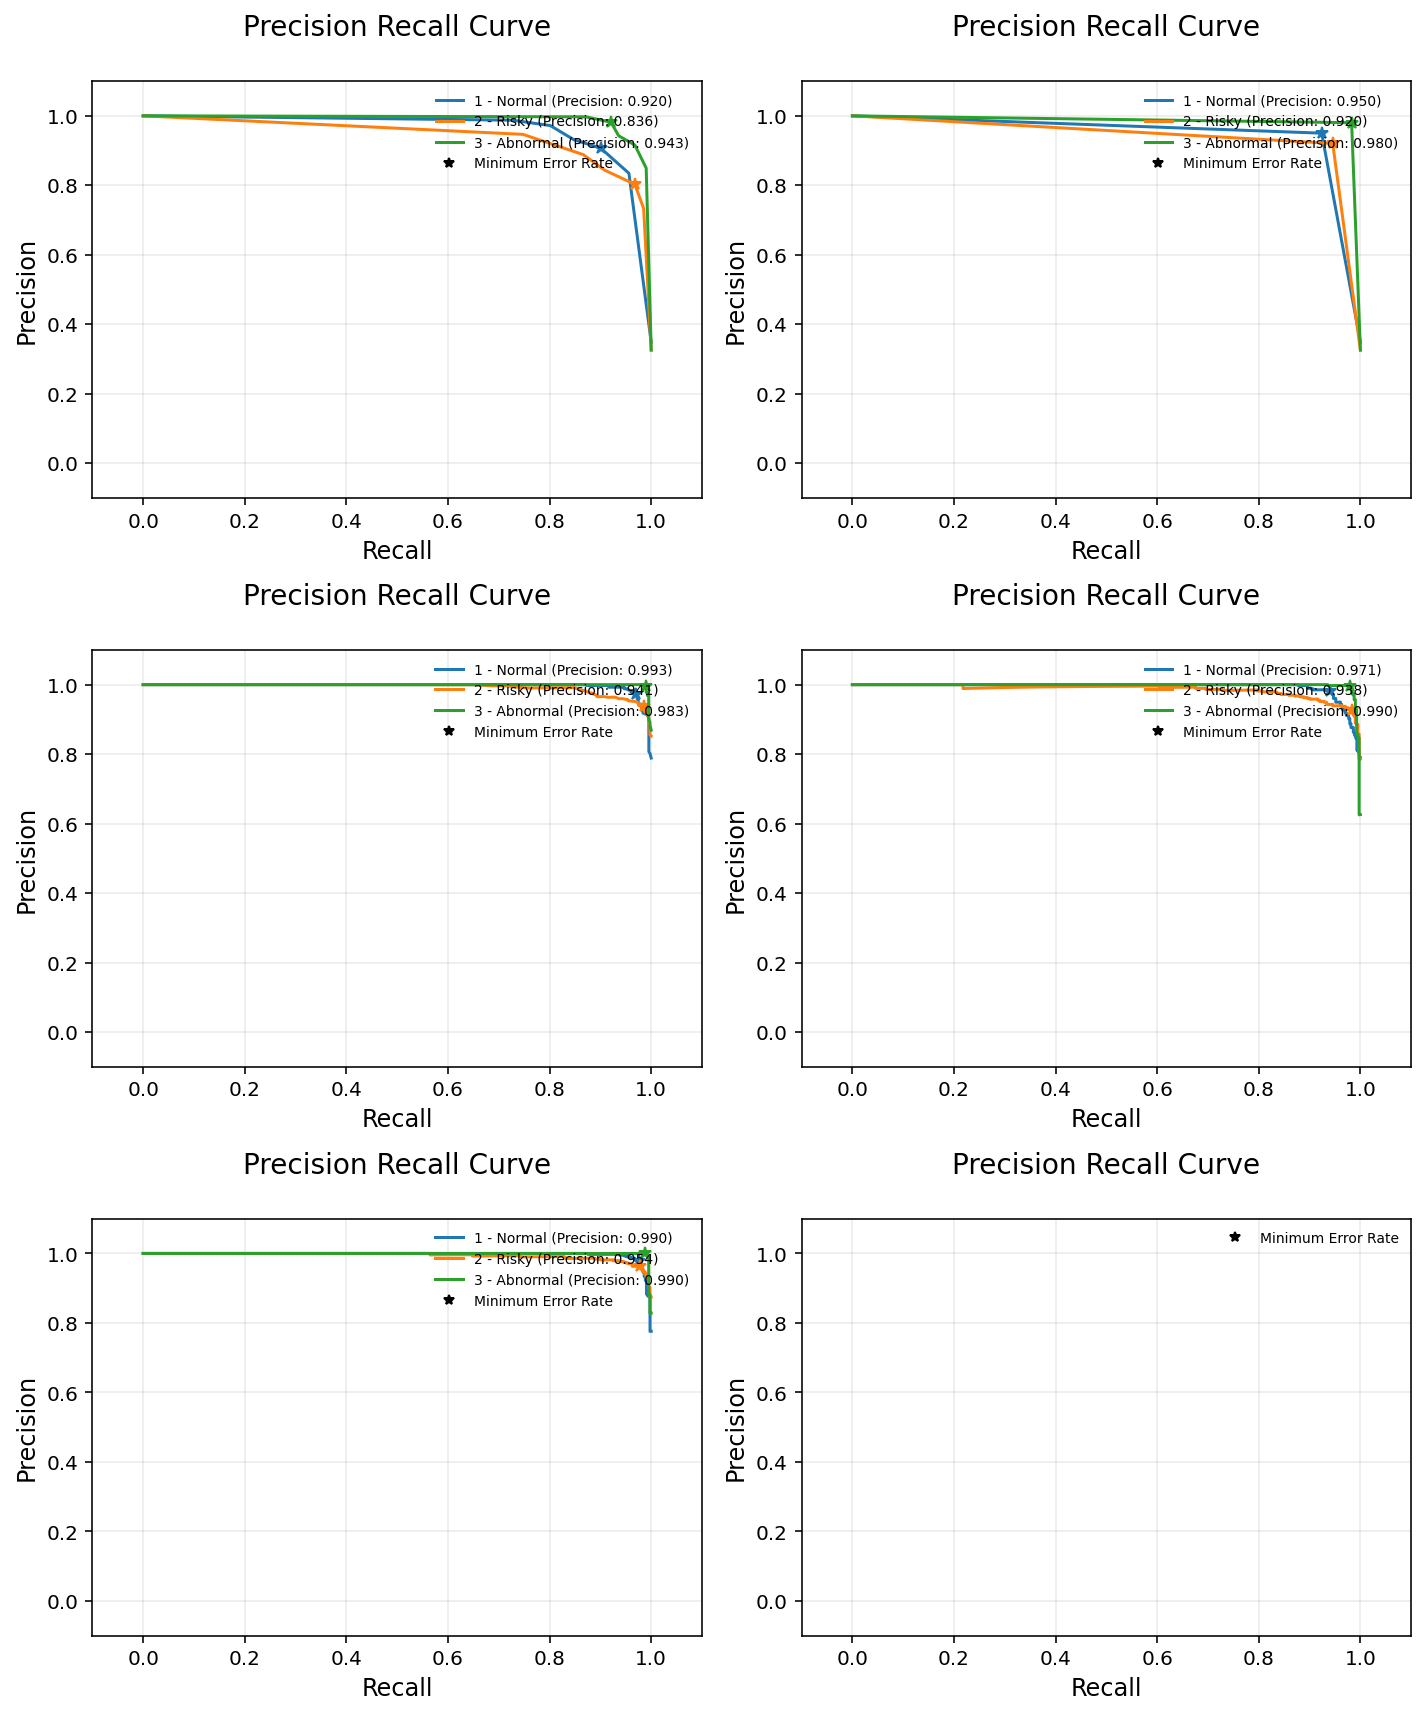

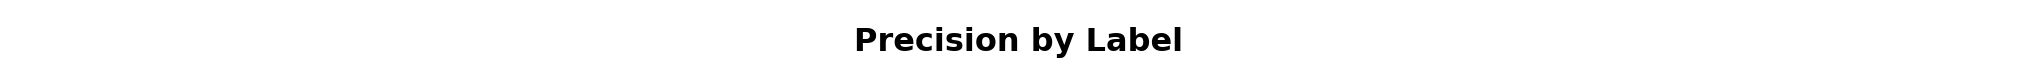

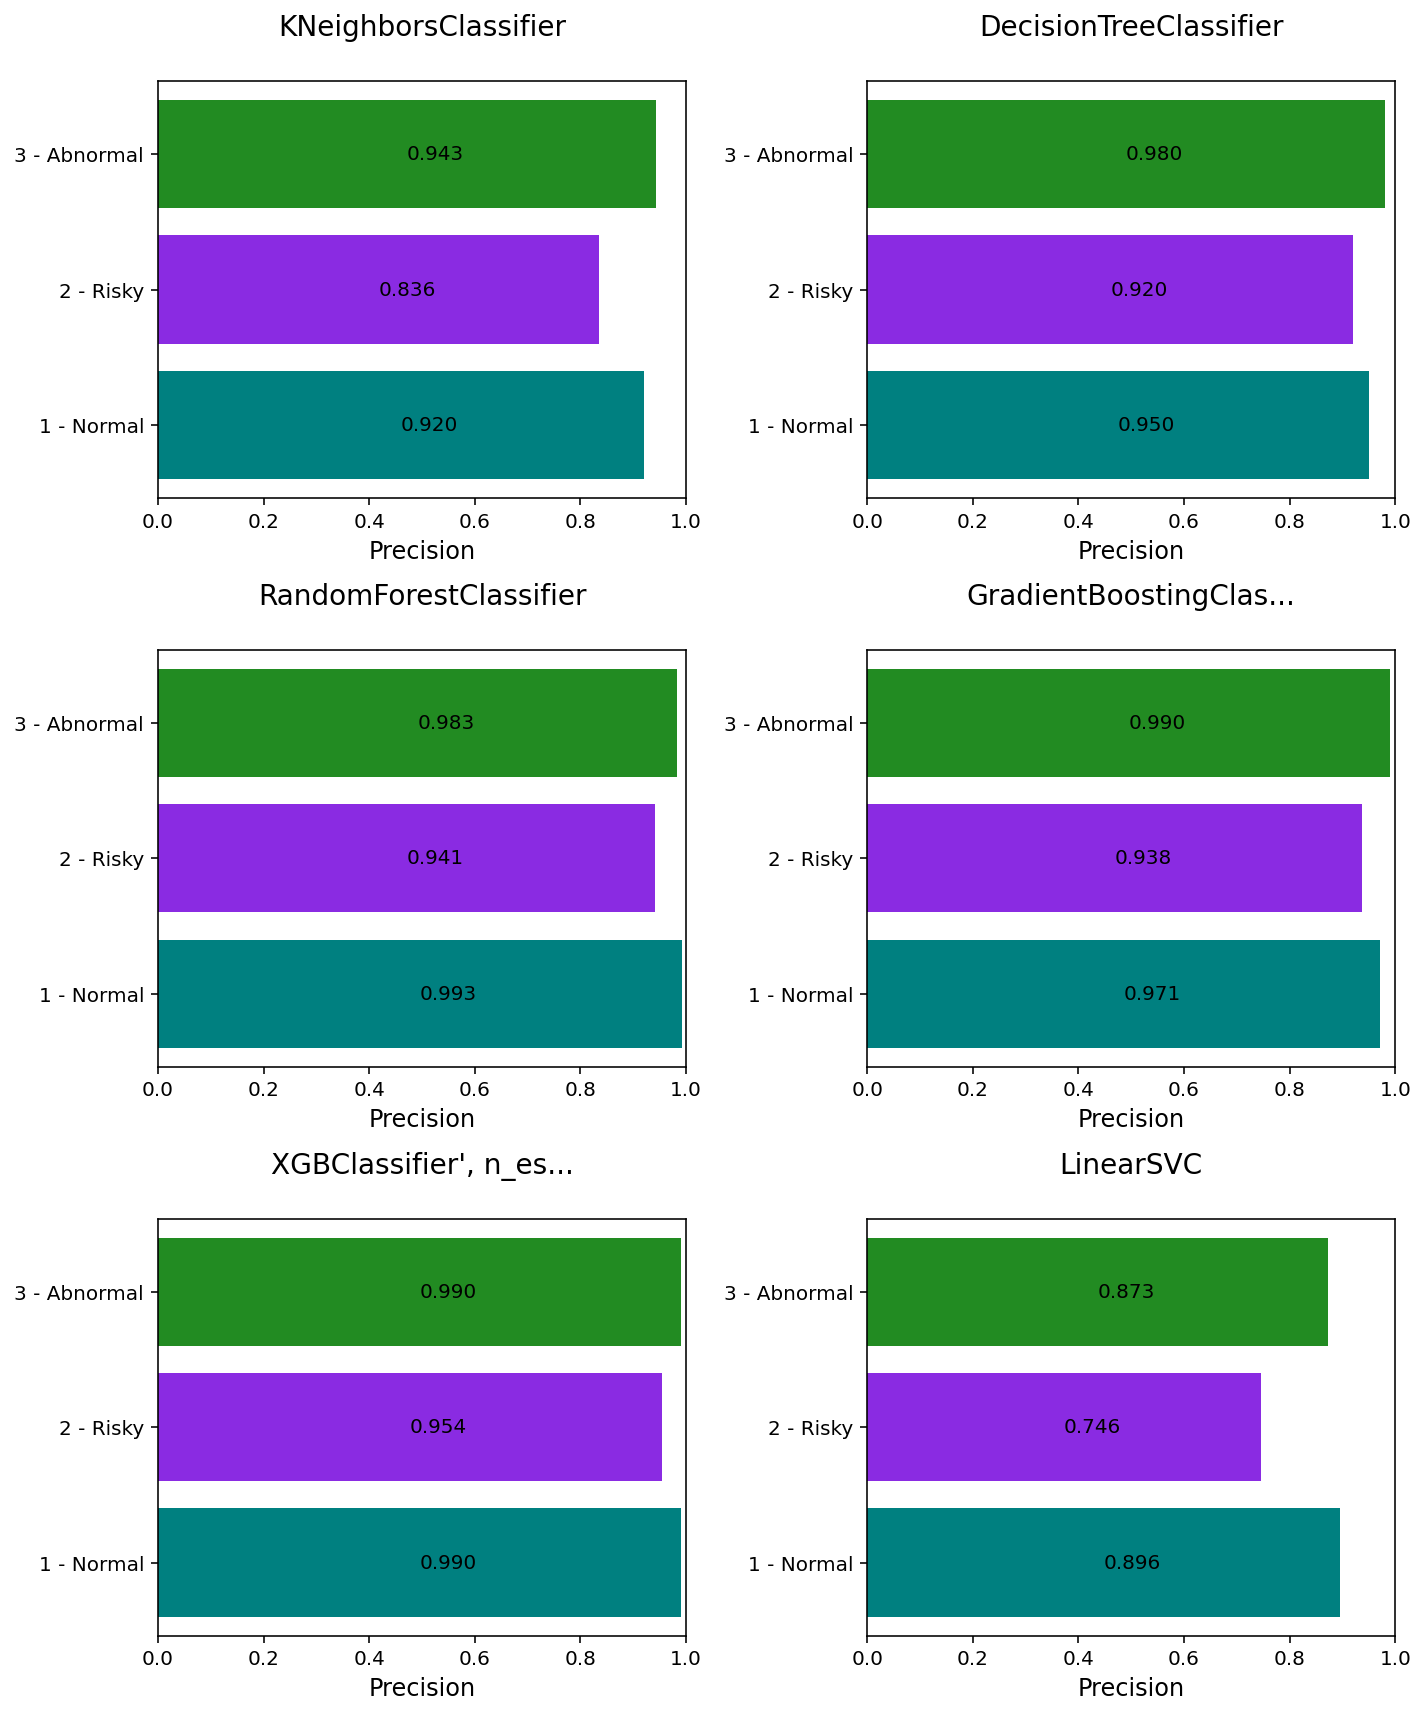

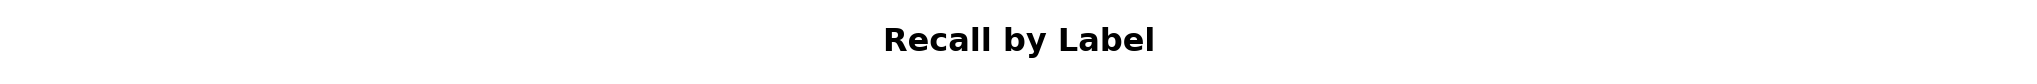

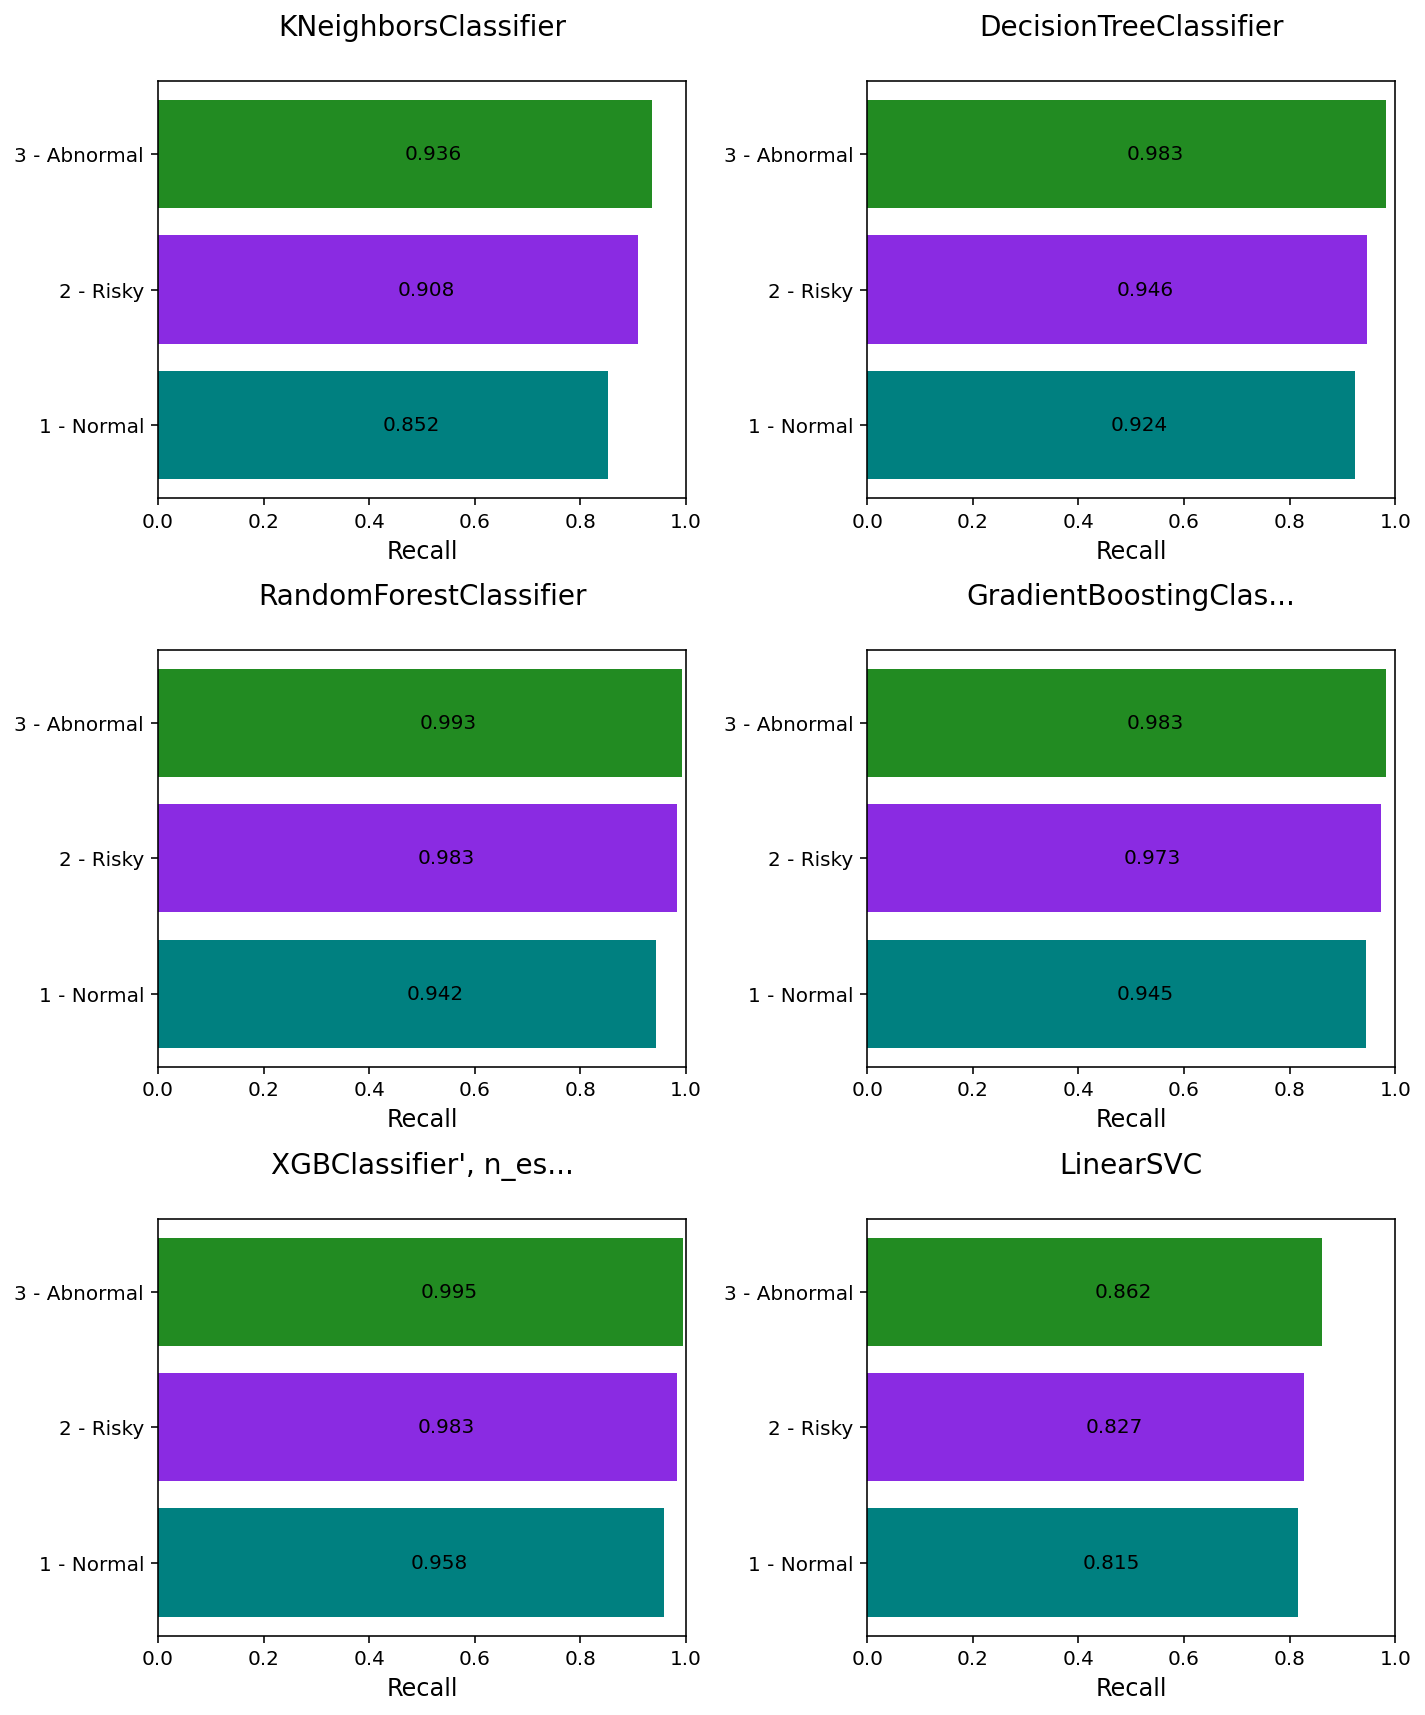

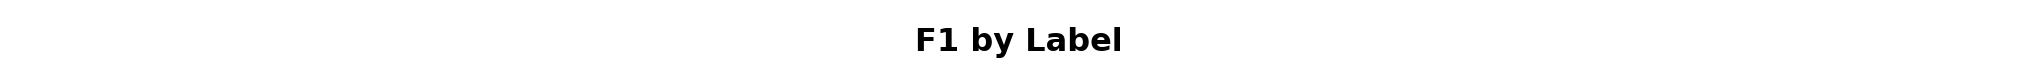

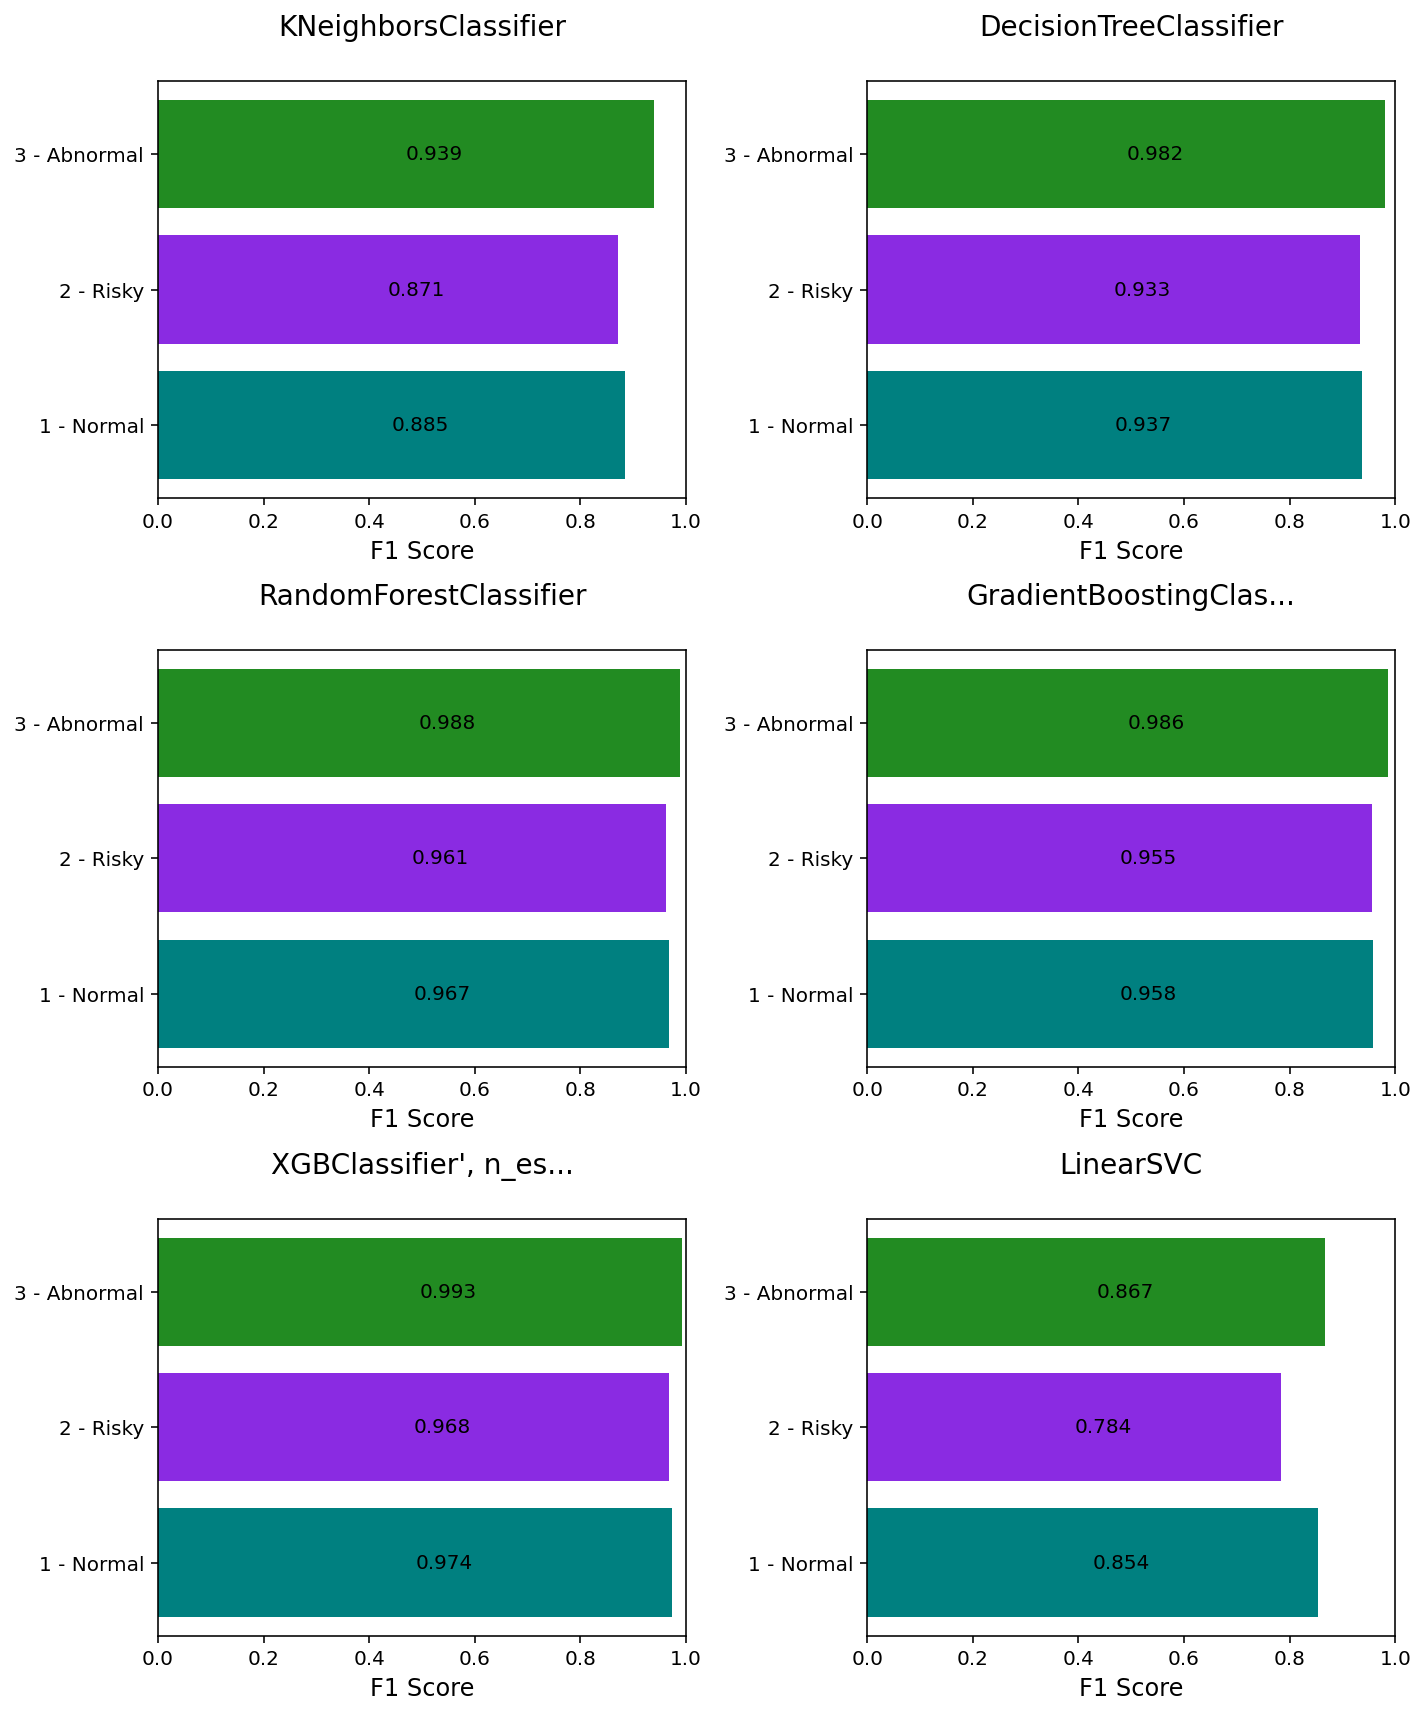

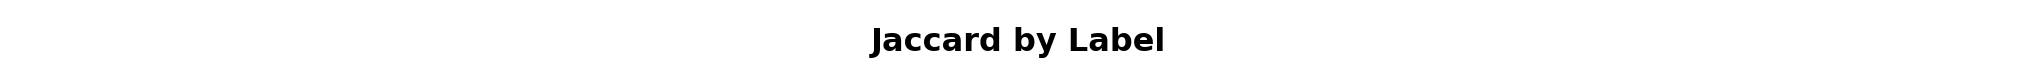

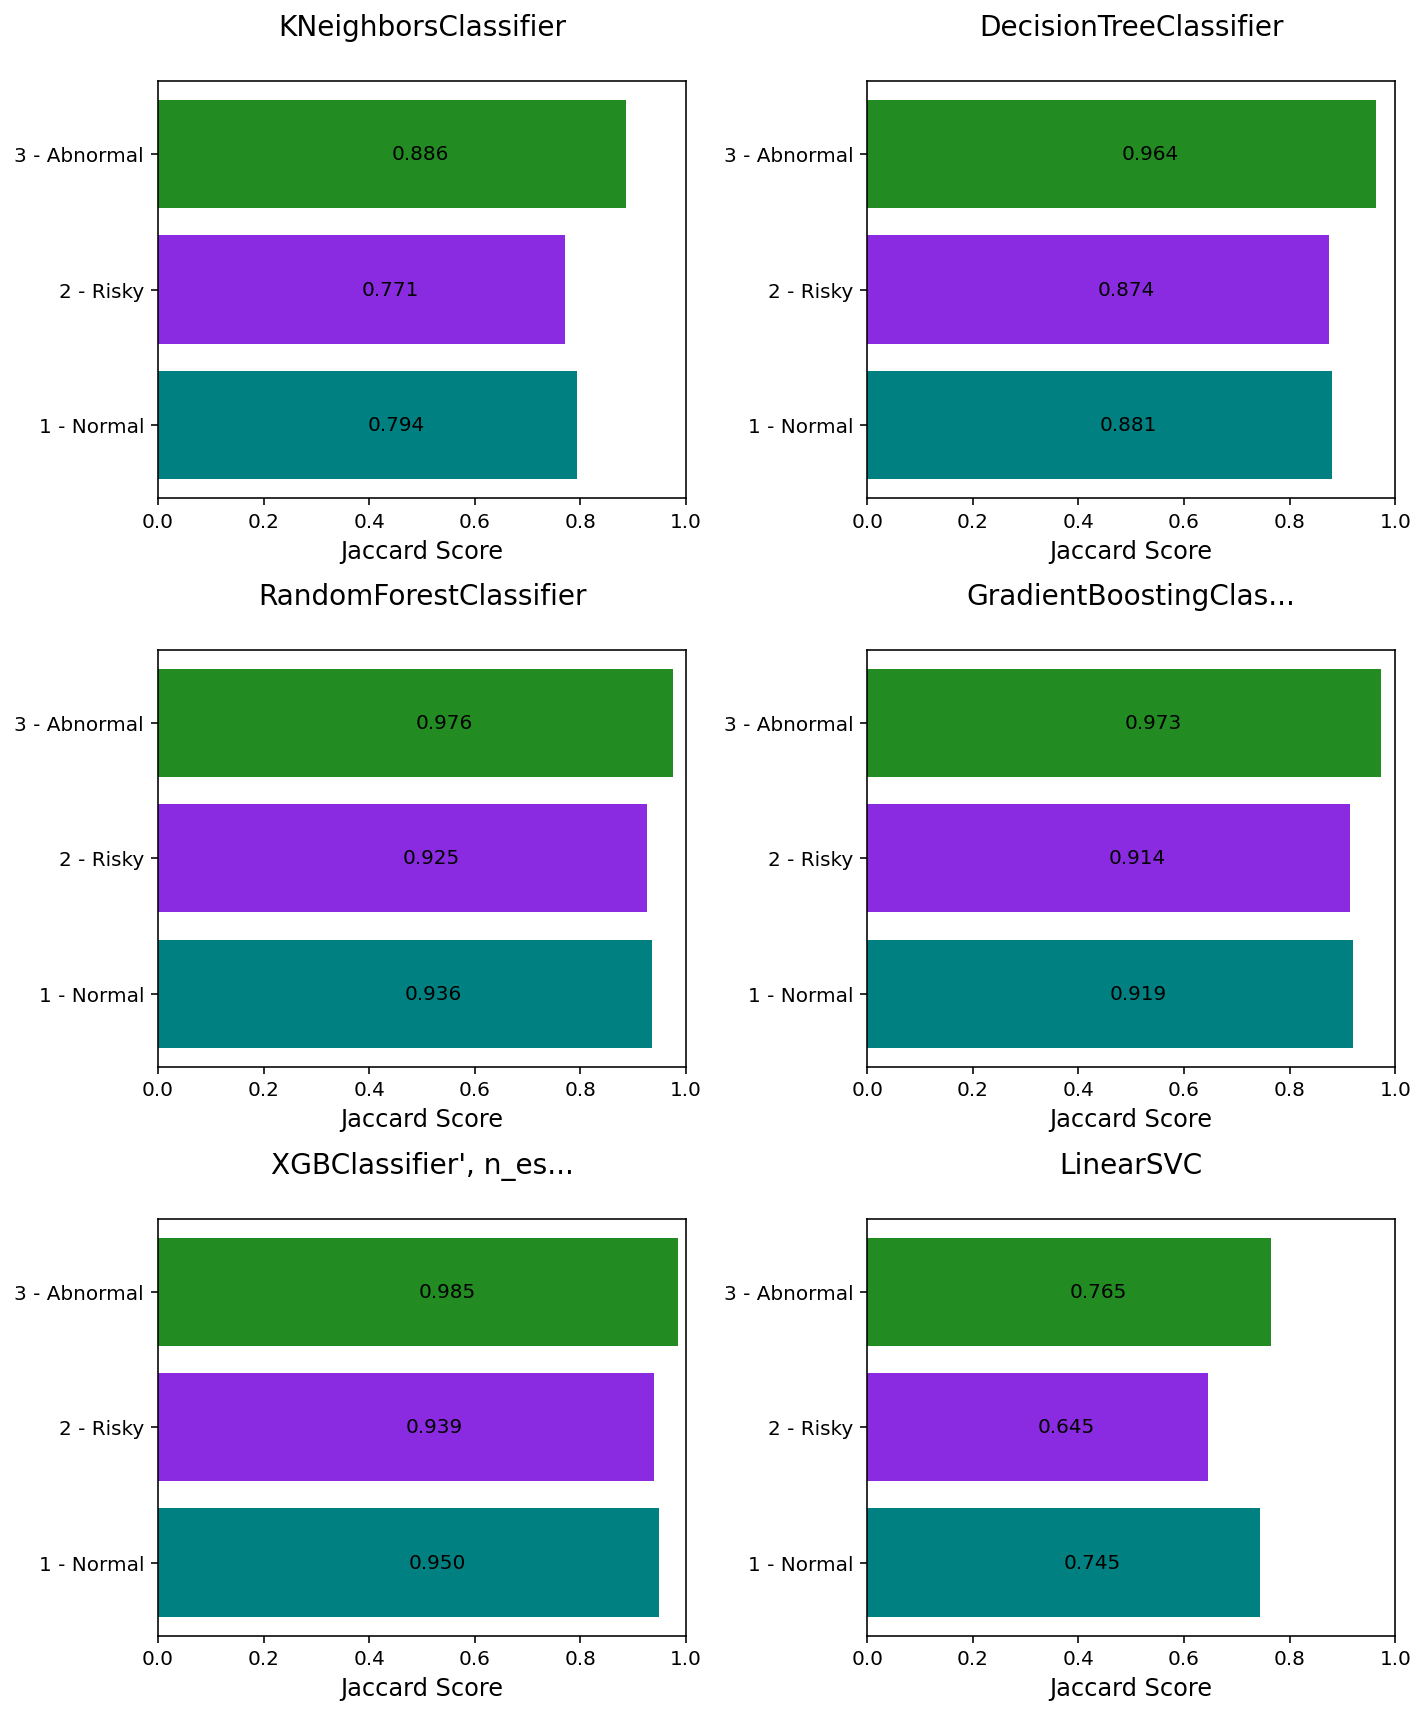

In [76]:
evaluator.show_in_notebook(perfect=True)

<a id='create_pipeline'></a>
## Create the Production Model

From the above testing, the X Gradient Boosted Tree classsifier (XBGClassifier) is the best choice, with the best performance on most metrics.

While creating a model to deploy for inference, the input data needs to be transformed the same way it was before it was fed to the classifier to train. In this case, this means selecting features by removing columns, and scaling the data. 

In the case of the XBGClassifier, scaling will not affect the classification, since it is a tree-based algorithm, while feature selection is more easily implemented by enforcing the input schema, so there is nothing to do but train the classifier.

The classifier is already trained previously, but it was trained in scaled features which we do not really need since it is a tree-based classfier. 

Ideally hyper-parameters tuning is performed for all models, to make sure our choice is still the best, and the model is tuned to best performance. This step is described in other notebooks, and is left as an exercise to the reader.

In [22]:
df4 = load_dataset()
df4[label_col] = df4[label_col].map({1.0: '1 - Normal', 2.0: '2 - Risky', 3.0: '3 - Abnormal'})
df4 = df4[list(selected_features) + [label_col]]

ds4 = DatasetFactory.from_dataframe(df4).set_target(label_col).up_sample()
train, test = ds4.train_test_split(0.25)

xgb_classifier = XGBClassifier(eval_metric='mlogloss')
xgb_classifier.fit(train.X, train.y)

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [23]:
xgb_classifier.score(test.X, test.y)

0.9782608695652174

Using the `predict` method, check the predictions on a few samples

In [24]:
xgb_classifier.predict(test.X[:5])

array(['2 - Risky', '1 - Normal', '1 - Normal', '3 - Abnormal',
       '1 - Normal'], dtype=object)

Verify that the predictions make sense

In [25]:
test.y[:5]

3137       2 - Risky
393       1 - Normal
1164      1 - Normal
4332    3 - Abnormal
731       1 - Normal
Name: fetal_health, dtype: object

<a id='serialize'></a>
# Model Deployment

The model is trained and working well. The next step is to make it available to the world to infer on unknown samples.

ADS model.framework makes it easy to deploy a model into production. It supports several types of models, including `AutoML`, `LightGBM`, `PyTorch`, `Sklearn`, `TensorFlow`, and `XGBoost` models. The constructor takes a model and converts it into an ADS object meant for model serialization and deployment. 

Deploying the model into production requires a few steps: `prepare` the model artifact, creating a bundle of files inference code, and metadata about the input and output schemas, the model provenance and environment where it was trained. `verify` the artifact, by testing the generated inference code locally. `save` the model to the model catalog, and then `deploy`. Once deployed, using the `predict` method calls the deployment endpoint to infere from the deployed model.

ADS provides the `.summary_status()` method that outputs a dataframe that defines the steps, status, and detailed information about each step. 

<a id='serialize_sklearnmodel'></a>
## Create a Serialized Model

From the testing above, it was determined that the XGBoostClassifier model was the best bet. 

The `XGBoostModel()` constructor takes a xgboost model along with the path where to store the model artifacts. An `XGBoostModel` object is returned, and it is used to manage the deployment.

The next cell creates a temporary model artifact directory, sets the authentication to use resource principal (required to check on deployment status), and creates the `XGBoostModel` object.

In [32]:
artifact_dir = tempfile.mkdtemp()
ads.set_auth(auth='resource_principal')
xgb_model = XGBoostModel(estimator=xgb_classifier, artifact_dir=artifact_dir)

The `.summary_status()` method of the `XGBoostModel` class is a handy method to keep track of the progress that you are making in deploying the model. It creates a dataframe that lists the deployment steps, thier status, and details about them. The next cell returns the summary status dataframe. It shows that the initiate step has been completed.

In [33]:
xgb_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Available     Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Not Available Local tested .predict from score.py                               
save()    Not Available Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

<a id='serialize_prepare'></a>
## Prepare the Model Artifacts

The prepare step is performed by the `.prepare()` method of the `XGBoostModel` class. It creates a number of customized files that are used to run the model once it is deployed. These include:

* `input_schema.json`: A JSON file that defines the nature of the features of the `X_sample` data. It includes metadata such as the data type, name, constraints, summary statistics, feature type, and more.
* `model.joblib`: This is the default filename of the serialized model. It can be changed with the `model_file_name` attribute. By default, the model is stored in a joblib file. The parameter `as_onnx` can be used to save it in the ONNX format.
* `output_schema.json`: A JSON file that defines the nature of the dependent variable in the `y_sample` data. It includes metadata such as the data type, name, constraints, summary statistics, feature type, and more.
* `runtime.yaml`: This file contains information that is needed to set up the runtime environment on the deployment server. It has information about which conda environment was used to train the model, and what environment should be used to deploy the model. The file also specifies what version of Python should be used.
* `score.py`: This script contains the `load_model()` and `predict()` functions. The `load_model()` function understands the format the model file was saved in and loads it into memory. The `.predict()` method is used to make inferences in a deployed model. There are also hooks that allow you to perform operations before and after inference. You can modify this script to fit your specific needs.

To create the model artifacts, you use the `.prepare()` method. There are a number of parameters that allow you to store model provenance information. In the next cell, the `conda_env` variable defines the slug of the conda environment that was used to train the model, and also the conda environment that should be used for deployment. Note that you can only pass in slugs to `inference_conda_env` or `training_conda_env` if it's a service environment. Otherwise, you must pass in the full path of the conda envvironment along with the python version through `inference_python_version` and `training_python_version`.

In [34]:
conda_env = 'generalml_p37_cpu_v1'

xgb_model.prepare(
    inference_conda_env=conda_env,
    training_conda_env=conda_env,
    use_case_type=UseCaseType.MULTINOMIAL_CLASSIFICATION,
    X_sample=X_test,
    y_sample=y_test,
)

The next cell uses the `.summary_status()` method to show you that the prepare step finished, and what tasks were completed.

In [35]:
xgb_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Available     Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

The `.prepare()` method has created the following files. These files are fully functional. However, you can modify them to fit your specific needs.

In [36]:
os.listdir(artifact_dir)

['input_schema.json',
 'score.py',
 'model.json',
 'runtime.yaml',
 'output_schema.json']

Once the artifacts have been created, there are a number of attributes in the `XGBoostModel` object that provides metadata about the model. The `.runtime` attribute details the model deployment settings and model provenance data.

In [37]:
xgb_model.runtime_info

model_artifact_version: '3.0'
model_deployment:
  inference_conda_env:
    inference_env_path: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/General_Machine_Learning_for_CPUs_on_Python_3.7/1.0/generalml_p37_cpu_v1
    inference_env_slug: generalml_p37_cpu_v1
    inference_env_type: data_science
    inference_python_version: '3.7'
model_provenance:
  project_ocid: ''
  tenancy_ocid: ''
  training_code:
    artifact_directory: /tmp/tmpbkypayvz
  training_compartment_ocid: ''
  training_conda_env:
    training_env_path: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/General_Machine_Learning_for_CPUs_on_Python_3.7/1.0/generalml_p37_cpu_v1
    training_env_slug: generalml_p37_cpu_v1
    training_env_type: data_science
    training_python_version: '3.7'
  training_region: ''
  training_resource_ocid: ''
  user_ocid: ''
  vm_image_internal_id: ''

The `.schema_input` attribute provides metadata on the features that were used to train the model. You can use this information to determine what data must be provided to make model inferences. Each feature in the model has a section that defines the dtype, feature type, name, and if it is required. The metadata also includes the summary statistics associated with the feature type.

In [38]:
xgb_model.schema_input

schema:
- description: light_decelerations
  domain:
    constraints: []
    stats:
      count: 1242.0
      lower quartile: -5.199
      mean: -2.67
      median: -5.199
      sample maximum: 3.101
      sample minimum: -5.199
      skew: 0.39
      standard deviation: 3.023
      upper quartile: 0.617
    values: Continuous
  dtype: float64
  feature_type: Continuous
  name: light_decelerations
  order: 3
  required: true
- description: mean_value_of_short_term_variability
  domain:
    constraints: []
    stats:
      count: 1242.0
      lower quartile: -0.736
      mean: -0.077
      median: 0.009
      sample maximum: 3.699
      sample minimum: -5.199
      skew: -1.678
      standard deviation: 1.318
      upper quartile: 0.669
    values: Continuous
  dtype: float64
  feature_type: Continuous
  name: mean_value_of_short_term_variability
  order: 7
  required: true
- description: histogram_mode
  domain:
    constraints: []
    stats:
      count: 1242.0
      lower quartile: -

The `.metadata_custom` attribute provides custom metadata that contains information on the category of the metadata, description, key, and value.

In [39]:
xgb_model.metadata_custom

data:
- category: Training Profile
  description: The model serialization format.
  key: ModelSerializationFormat
  value: json
- category: Training Environment
  description: The conda environment where the model was trained.
  key: CondaEnvironment
  value: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/General_Machine_Learning_for_CPUs_on_Python_3.7/1.0/generalml_p37_cpu_v1
- category: Training Environment
  description: The conda environment type, can be published or datascience.
  key: EnvironmentType
  value: data_science
- category: Training Environment
  description: The URI of the training conda environment.
  key: CondaEnvironmentPath
  value: oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/General_Machine_Learning_for_CPUs_on_Python_3.7/1.0/generalml_p37_cpu_v1
- category: Other
  description: ''
  key: ClientLibrary
  value: ADS
- category: Training Environment
  description: The slug name of the training conda environment.
  key: SlugName
  value: generalm

The `.metadata_provenance` contains information about the code and training data that was used to create the model. This information is most useful when a Git repository is being used to manage the code for training the model. This is considered a best practice because it allows you to do things like reproduce a model, perform forensic on the model, and so on.

In [40]:
xgb_model.metadata_provenance

artifact_dir: null
git_branch: null
git_commit: null
repo: null
repository_url: null
training_id: null
training_script_path: null

The `.metadata_taxonomy` is a key-value store that has information about the classification or taxonomy of the model. This can include information such as the model framework, use case type, hyperparameters, and more.

In [41]:
xgb_model.metadata_taxonomy

data:
- key: Algorithm
  value: XGBClassifier
- key: FrameworkVersion
  value: 1.5.1
- key: ArtifactTestResults
  value: null
- key: Framework
  value: xgboost
- key: Hyperparameters
  value:
    base_score: 0.5
    booster: gbtree
    colsample_bylevel: 1
    colsample_bynode: 1
    colsample_bytree: 1
    enable_categorical: false
    eval_metric: mlogloss
    gamma: 0
    gpu_id: -1
    importance_type: null
    interaction_constraints: ''
    learning_rate: 0.300000012
    max_delta_step: 0
    max_depth: 6
    min_child_weight: 1
    missing: .nan
    monotone_constraints: ()
    n_estimators: 100
    n_jobs: 4
    num_parallel_tree: 1
    objective: multi:softprob
    predictor: auto
    random_state: 0
    reg_alpha: 0
    reg_lambda: 1
    scale_pos_weight: null
    subsample: 1
    tree_method: exact
    use_label_encoder: true
    validate_parameters: 1
    verbosity: null
- key: UseCaseType
  value: multinomial_classification

<a id='serialize_verify'></a>
## Verify: Test the Model Locally

If you modify the `score.py` file that is part of the model artifacts, then you should verify it. The verify step allows you to test those changes without having to deploy the model. This allows you to debug your code without having to save the model to the model catalog and then deploy it. The `.verify()` method takes a set of test parameters and performs the prediction by calling the `predict` function in `score.py`. It also runs the `load_model` function.

The next cell simulates a call to a deployed model without having to actually deploy the model. It passes in test values and returns the predictions.

In [42]:
df4[:10]

,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_variance,histogram_tendency,fetal_health
0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,73.0,0.5,43.0,2.4,64.0,62.0,126.0,0.0,120.0,137.0,73.0,1.0,2 - Risky
1,0.006380,0.0,0.006380,0.003190,0.0,0.000000,17.0,2.1,0.0,10.4,130.0,68.0,198.0,1.0,141.0,136.0,12.0,0.0,1 - Normal
2,0.003322,0.0,0.008306,0.003322,0.0,0.000000,16.0,2.1,0.0,13.4,130.0,68.0,198.0,1.0,141.0,135.0,13.0,0.0,1 - Normal
3,0.002561,0.0,0.007682,0.002561,0.0,0.000000,16.0,2.4,0.0,23.0,117.0,53.0,170.0,0.0,137.0,134.0,13.0,1.0,1 - Normal
4,0.006515,0.0,0.008143,0.000000,0.0,0.000000,16.0,2.4,0.0,19.9,117.0,53.0,170.0,0.0,137.0,136.0,11.0,1.0,1 - Normal
5,0.001049,0.0,0.010493,0.009444,0.0,0.002099,26.0,5.9,0.0,0.0,150.0,50.0,200.0,3.0,76.0,107.0,170.0,0.0,3 - Abnormal
6,0.001403,0.0,0.012623,0.008415,0.0,0.002805,29.0,6.3,0.0,0.0,150.0,50.0,200.0,3.0,71.0,107.0,215.0,0.0,3 - Abnormal
7,0.000000,0.0,0.000000,0.000000,0.0,0.000000,83.0,0.5,6.0,15.6,68.0,62.0,130.0,0.0,122.0,122.0,3.0,1.0,3 - Abnormal
8,0.000000,0.0,0.001517,0.000000,0.0,0.000000,84.0,0.5,5.0,13.6,68.0,62.0,130.0,0.0,122.0,122.0,3.0,1.0,3 - Abnormal
9,0.000000,0.0,0.002967,0.000000,0.0,0.000000,86.0,0.3,6.0,10.6,68.0,62.0,130.0,0.0,122.0,122.0,1.0,1.0,3 - Abnormal


In [44]:
xgb_model.verify(df4[:10][list(selected_features)])

Start loading model.json from model directory /tmp/tmpbkypayvz ...
Model is successfully loaded.


{'prediction': [[0.0007631700718775392,
   0.997192919254303,
   0.0020439215004444122],
  [0.999957799911499, 4.116282798349857e-05, 1.043181327986531e-06],
  [0.9999662637710571, 3.20240251312498e-05, 1.7002713548208703e-06],
  [0.9999802112579346, 1.8105029084836133e-05, 1.6622293514956255e-06],
  [0.9999897480010986, 9.118786692852154e-06, 1.1435583928687265e-06],
  [0.0030947530176490545, 0.019832275807857513, 0.9770729541778564],
  [0.00037672792677767575, 0.0013934496091678739, 0.9982298016548157],
  [0.0001640246919123456, 0.0005388980498537421, 0.999297022819519],
  [0.00016283438890241086, 0.0006155945593491197, 0.9992215633392334],
  [0.005359556060284376, 0.0002829868462868035, 0.9943574070930481]]}

The `.summary_status()` method is updated to show that the verify step has been completed.

In [45]:
xgb_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done          Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

<a id='serialize_save'></a>
## Save the Model in the Model Catalog

Once you are satisfied with the performance of the model and have verified that the `score.py` file is working, you can save the model to the model catalog. You do this with the `.save()` method on a `XGBoostModel` object. This bundles up the model artifact that you have created, and push it to the model catalog. It returns the model OCID. It's important to keep track of this id, as it is used to delete the model later.

In [47]:
model_id = xgb_model.save(display_name='fetal_health_demo')

Start loading model.json from model directory /tmp/tmpbkypayvz ...
Model is successfully loaded.
['input_schema.json', 'score.py', 'model.json', 'runtime.yaml', 'output_schema.json']


loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_88a6ec24-1f97-4df7-aa56-e3bcf5deb606.zip


In [48]:
model_id

'ocid1.datasciencemodel.oc1.phx.amaaaaaanif7xwia4ltne3ya43jzbhwberxkldneckmmeru5o3iwfen2rwma'

<a id='serialize_deploy'></a>
## Deploy

With the model in the model catalog, you can use the `.deploy()` method to deploy the model. This method allows you to specify the attributes of the deployment such as the display name, description, instance type and count, the maximum bandwidth, and logging groups. The next cell deploys the model with the default settings, except for the custom display name. The `.deploy()` method returns a `ModelDeployment` object.

In [49]:
deployment = xgb_model.deploy(display_name='fetal_health_demo_model_deployment')

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

After deployment, the `.summary_status()` method shows that the model is ACTIVE and the `predict()` method is available.

In [50]:
xgb_model.summary_status()

Actions Needed
Step      Status    Details                                                           
initiate  Done      Initiated the model                                               
prepare() Done      Generated runtime.yaml                                            
                    Generated score.py                                                
                    Serialized model                                                  
                    Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done      Local tested .predict from score.py                               
save()    Done      Conducted Introspect Test                                         
                    Uploaded artifact to model catalog                                
deploy()  ACTIVE    Deployed the model                                                
predict() Available Called deployment predict endpoint

<a id='serialize_predict'></a>
## Predict

Earlier you used the `model.predict()` method where `model` was an `ADSModel` object. This did inference using the local model. Now that the `XGBoostModel` model has been deploy, the `.predict()` method is available to do inference on the deployed model. It effectively calls the deployed model endpoint.


In [53]:
xgb_model.predict(df4[:2][list(selected_features)])

{'prediction': [[0.0007631700718775392,
   0.997192919254303,
   0.0020439215004444122],
  [0.999957799911499, 4.116282798349857e-05, 1.043181327986531e-06]]}

<a id='req_resp'></a>
## Invoking the REST Endpoint

To invoke the RESRT endpoint, JSON data needs to be passed to the HTTP call. The test data is created from raw data by selecting the appropriate columns and exporting to JSON with pandas `to_json` method.

Then a HTTP POST request is sent to the endpoint, and results are received as JSON.

In [54]:
input_data = df4[:2][list(selected_features)].to_json(orient='records')
endpoint = f"{deployment.url}/predict"
auth = oci.auth.signers.get_resource_principals_signer()

requests.post(endpoint, json={'data': input_data, 'data_type':"pandas.core.frame.DataFrame"}, auth=auth).json()

{'prediction': [[0.0007631700718775392,
   0.997192919254303,
   0.0020439215004444122],
  [0.999957799911499, 4.116282798349857e-05, 1.043181327986531e-06]]}

<a id='clean_up'></a>
# Clean Up

This notebook created a model deployment and a model. This section cleans up those resources. 

The model deployment must be deleted before the model can be deleted. You use the `.delete_deployment()` method on the `SklearnModel` object to do this.

In [55]:
delete = xgb_model.delete_deployment(wait_for_completion=True)

After the model deployment has been deleted, the `.summary_status()` method shows that the model has been deleted and that the `predict()` method is not available.

In [56]:
xgb_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done          Local tested .predict from score.py                               
save()    Done          Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  DELETED       Deployed the model                                                
predict() Not Available Called deployment predict endpoint

Use the `.delete_model()` method in a `ModelCatalog` object to delete the model.

In [57]:
ModelCatalog(compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID']).delete_model(model_id)

True

The next cell removes the model artifacts that were stored on your local drive.

In [58]:
rmtree(artifact_dir)

<a id='ref'></a>
# References
- [ADS Library Documentation](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)
- [Understanding Conda Environments](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/use-notebook-sessions.htm#conda_understand_environments)
- [Use Resource Manager to Configure Your Tenancy for Data Science](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/orm-configure-tenancy.htm)
- [`runtime.yaml`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_runtime_yaml.htm#model_runtime_yaml)
- [`score.py`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_score_py.htm#model_score_py)
- [Model artifact](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/models_saving_catalog.htm#create-models)
- [ONNX API Summary](http://onnx.ai/sklearn-onnx/api_summary.html)